In [ ]:
##Cap 1 - Aprendendo com os dados da organização

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from statsmodels.tsa.stattools import adfuller
from datetime import datetime

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving vendas_linha_petshop_2019.csv to vendas_linha_petshop_2019.csv
Saving vendas_linha_petshop_2020.csv to vendas_linha_petshop_2020.csv
Saving vendas_linha_petshop_2021.csv to vendas_linha_petshop_2021.csv
Saving vendas_linha_petshop_2022.xlsx to vendas_linha_petshop_2022.xlsx
Saving vendas_linha_petshop_2023.xlsx to vendas_linha_petshop_2023.xlsx


In [ ]:
vendas_2019 = pd.read_csv('vendas_linha_petshop_2019.csv', encoding='ISO-8859-1', delimiter=';')
vendas_2020 = pd.read_csv('vendas_linha_petshop_2020.csv', encoding='ISO-8859-1', delimiter=';')
vendas_2021 = pd.read_csv('vendas_linha_petshop_2021.csv', encoding='ISO-8859-1', delimiter=';')
vendas_2022 = pd.read_excel('vendas_linha_petshop_2022.xlsx')
vendas_2023 = pd.read_excel('vendas_linha_petshop_2023.xlsx')

In [ ]:
# Atribuir novos nomes diretamente às colunas
vendas_2022.columns = ['regiao_pais', 'produto', 'valor', 'quantidade', 'valor_total_bruto', 'data', 'estado', 'formapagto', 'centro_distribuicao', 'responsavelpedido', 'valor_comissao', 'lucro_liquido', 'categoriaprod']
vendas_2023.columns = ['regiao_pais', 'produto', 'valor', 'quantidade', 'valor_total_bruto', 'data', 'estado', 'formapagto', 'centro_distribuicao', 'responsavelpedido', 'valor_comissao', 'lucro_liquido', 'categoriaprod']

In [ ]:
# Dropar coluna de codigos do pedido, porque 2 das planilhas não tem essa coluna
vendas_2019 = vendas_2019.drop('cod_pedido', axis=1)
vendas_2020 = vendas_2020.drop('cod_pedido', axis=1)
vendas_2021 = vendas_2021.drop('cod_pedido', axis=1)

In [ ]:
#Unindo os DF

lista_de_dfs = [vendas_2019, vendas_2020, vendas_2021, vendas_2022, vendas_2023]
df = pd.concat(lista_de_dfs, ignore_index=True)

In [ ]:
#Criando um índice personalizado pra substituir o código do pedido que dropamos
df['indice_personalizado'] = range(1, len(df) + 1)
df.set_index('indice_personalizado', inplace=True)
df_pre = df.copy()

In [ ]:
#Verificando o número de linhas
num_linhas = df.shape[0]
print(f"O DataFrame tem {num_linhas} linhas.")


O DataFrame tem 250060 linhas.


**Exercício 1**

In [ ]:
missing_count = df.isnull().sum()
print(missing_count)
total_missing_count = missing_count.sum()
print(f"Total de valores ausentes: {total_missing_count}")


regiao_pais              0
produto                  0
valor                    0
quantidade             332
valor_total_bruto       20
data                     0
estado                   0
formapagto               0
centro_distribuicao      0
responsavelpedido        0
valor_comissao          21
lucro_liquido           21
categoriaprod            0
dtype: int64
Total de valores ausentes: 394


Existem dados nulos nas colunas "quantidade", "valor_total_bruto", "valor_comissao" e "lucro_liquido".

Nos casos em que temos dados nulos em "quantidade" e as colunas "valor" e "valor_total_bruto" estão preenchidas é possível corrigir isso já que em todos os casos o valor_total_bruto = quantidade * valor.

Entretanto, nem sempre isso é possível de ser feito. Se tivéssemos dados nulos em data, por exemplo, e fosse necessário para uma análise, precisaríamos provavelmente dropar essas linhas com dados faltantes.

In [ ]:
df_tratamento = df.copy()

In [ ]:
df_tratamento['valor'] = df_tratamento['valor'].apply(lambda x: x.replace(',', '.') if ',' in str(x) else x)
df_tratamento['valor'] = pd.to_numeric(df_tratamento['valor'], errors='coerce')
df_tratamento['valor_total_bruto'] = df_tratamento['valor_total_bruto'].apply(lambda x: x.replace(',', '.') if ',' in str(x) else x)
df_tratamento['valor_total_bruto'] = pd.to_numeric(df_tratamento['valor_total_bruto'], errors='coerce')

#pegando apenas quando temos quantidade null e o resto não null
df_tratamento['quantidade_tratada'] = df_tratamento.valor_total_bruto / df_tratamento.valor
df_tratamento['quantidade_tratada']

#alguns valores ficaram claramente inconsistentes, a ser investigado posteriormente
df_tratamento['quantidade'] = df_tratamento['quantidade'].fillna(df_tratamento['quantidade_tratada'])

#validando que não tem mais nenhum nulo
df_tratamento['quantidade'].isnull().sum()

0

In [ ]:
#agora vamos avaliar quando valor_total_bruto é NaN. Seria possível também fazer o cálculo se a coluna quantidade estivesse preenchida de maneira correta.
#Como não está, será necessário dropar essas colunas.
df_tratamento[df_tratamento['valor_total_bruto'].isna()]
df_tratamento = df_tratamento.dropna(subset=['valor_total_bruto'])

In [ ]:
#revendo os missing values
missing_count = df_tratamento.isnull().sum()
print(missing_count)
total_missing_count = missing_count.sum()
print(f"Total de valores ausentes: {total_missing_count}")


regiao_pais             0
produto                 0
valor                   1
quantidade              0
valor_total_bruto       0
data                    0
estado                  0
formapagto              0
centro_distribuicao     0
responsavelpedido       0
valor_comissao          0
lucro_liquido           0
categoriaprod           0
quantidade_tratada     49
dtype: int64
Total de valores ausentes: 50


**Exercício 2**

In [ ]:
df_tratamento['quantidade'].describe()

count     250039
unique        73
top            1
freq       56055
Name: quantidade, dtype: object

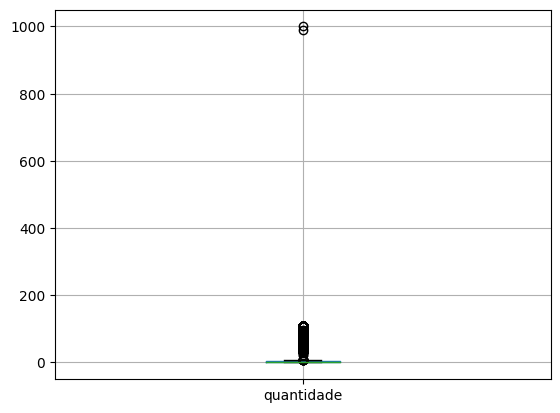

In [ ]:
#Transformando a coluna quantidade em numerica, substituindo possíveis pontos e letras antes de usar o coerce
df['quantidade'] = df['quantidade'].astype(str)
df['quantidade'] = pd.to_numeric(df['quantidade'].str.replace('[^\d.,]', '', regex=True), errors='coerce')

#Identificar outliers usando o método IQR
Q1 = df['quantidade'].quantile(0.25)
Q3 = df['quantidade'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['quantidade'] < lower_bound) | (df['quantidade'] > upper_bound)]

#Visualizar os outliers
df.boxplot(column='quantidade')
plt.show()


Antes de alguns tratamentos, existiam quantidades "negativas". Nesse caso, poderíamos dizer que provavelmente eram dados inválidos/inconsistentes/com algum erro.
Já com os dados após os tratamentos, vemos uma grande concentração de pedidos com até 2 itens (75% dos pedidos). E temos como máximo a quantidade de 88, que ainda é algo normal, não daria para afirmarmos que é um erro/algo suspeito.

**Exercício 3**

In [ ]:
#Verificando o tipo de dado:
tipo_dado_1 = df['valor_total_bruto'].dtype
print(f"Tipo de dado da coluna 'valor_total_bruto': {tipo_dado_1}")

tipo_dado_2 = df['quantidade'].dtype
print(f"Tipo de dado da coluna 'quantidade': {tipo_dado_2}")

tipo_dado_3 = df['valor'].dtype
print(f"Tipo de dado da coluna 'valor': {tipo_dado_3}")

#transformando as colunas do valor bruto para numerica (para nao dar erro)
#combined_df['valor_total_bruto'] = pd.to_numeric(combined_df['valor_total_bruto'], errors='coerce')


Tipo de dado da coluna 'valor_total_bruto': object
Tipo de dado da coluna 'quantidade': float64
Tipo de dado da coluna 'valor': object


In [ ]:
#Transformando o valor_total_bruto em float para permitir cálculos
#df['valor_total_bruto'] = df['valor_total_bruto'].str.replace(',', '.', regex=True)
#df['valor_total_bruto'] = df['valor_total_bruto'].str.replace('[^\d.]', '', regex=True)
#df['valor_total_bruto'] = df['valor_total_bruto'].astype(float)

#Transformando o valor em float para permitir cálculos
#df['valor'] = df['valor'].str.replace(',', '.', regex=True)
#df['valor'] = df['valor'].str.replace('[^\d.]', '', regex=True)
#df['valor'] = pd.to_numeric(df['valor'], errors='coerce')

#Lida com valores infinitos substituindo por 0
#df['quantidade'] = df['quantidade'].replace([float('inf'), float('-inf')], 0)

#Substitui valores não finitos por 0 antes de converter para int
#df['quantidade'] = df['quantidade'].fillna(0).astype(int)
#print(df)


In [ ]:
# Check data types
print("Data Types in df_tratamento:")
print(df_tratamento.dtypes)

print("Data Types in df:")
print(df.dtypes)

# Inspect data in the 'valor_total_calculado' and 'valor_total_bruto' columns
print("Sample data in df_tratamento['valor_total_calculado']:")
print(df_tratamento['valor_total_calculado'].head())

print("Sample data in df['valor_total_bruto']:")
print(df['valor_total_bruto'].head())


Data Types in df_tratamento:
regiao_pais               object
produto                   object
valor                    float64
quantidade               float64
valor_total_bruto        float64
data                      object
estado                    object
formapagto                object
centro_distribuicao       object
responsavelpedido         object
valor_comissao            object
lucro_liquido             object
categoriaprod             object
quantidade_tratada       float64
valor_total_calculado    float64
dtype: object
Data Types in df:
regiao_pais             object
produto                 object
valor                  float64
quantidade             float64
valor_total_bruto      float64
data                    object
estado                  object
formapagto              object
centro_distribuicao     object
responsavelpedido       object
valor_comissao          object
lucro_liquido           object
categoriaprod           object
dtype: object
Sample data in df_tratament

In [ ]:
df_tratamento['valor'] = pd.to_numeric(df_tratamento['valor'], errors='coerce')
df_tratamento.reset_index(drop=True, inplace=True)

# Redefinir o índice de df para o índice padrão
df.reset_index(drop=True, inplace=True)

# Calcular o valor total bruto com base em valor e quantidade (total = valor * quantidade)
df_tratamento['valor_total_calculado'] = df_tratamento['valor'] * df_tratamento['quantidade']

# Verificar se os valores na coluna 'valor_total_bruto' correspondem ao valor calculado
df_inconsistentes = df_tratamento[df_tratamento['valor_total_calculado'] != df['valor_total_bruto']]

df_inconsistentes.shape[0]

ValueError: ignored

Os inconsistentes foram eliminados na limpeza dos valores nulos.


In [ ]:
df_tratamento['valor_total_calculado'].describe()

count     92397.000000
mean        334.975612
std        2648.321845
min           5.600000
25%          35.840000
50%          63.840000
75%         114.240000
max      104165.600000
Name: valor_total_calculado, dtype: float64

In [ ]:
df_tratamento[df_tratamento['valor_total_calculado']==104165.6]

,regiao_pais,produto,valor,quantidade,valor_total_bruto,data,estado,formapagto,centro_distribuicao,responsavelpedido,valor_comissao,lucro_liquido,categoriaprod,quantidade_tratada,valor_total_calculado
indice_personalizado,,,,,,,,,,,,,,,
86702,Sudeste,Nutri Alimentador Inteligente Automático Câmer...,1183.7,88,104165.6,25/12/2021,Minas Gerais,Cartão Débito,Papa Léguas,Monique,"5482,4",23496,Bebedouros e Comedouros,88.0,104165.6
91622,Norte,Nutri Alimentador Inteligente Automático Câmer...,1183.7,88,104165.6,02/10/2021,Amapá,Boleto Bancário,Rapid Pink,Maria Linda,"5482,4",23496,Bebedouros e Comedouros,88.0,104165.6


In [ ]:
#Analisando valores mínimo, máximo, média e mediana:

min_valor = combined_df['valor_total_bruto'].min()
max_valor = combined_df['valor_total_bruto'].max()
print(f"Valor mínimo: {min_valor}")
print(f"Valor máximo: {max_valor}")

media = combined_df['valor_total_bruto'].mean()
mediana = combined_df['valor_total_bruto'].median()
print(f"Média: {media}")
print(f"Mediana: {mediana}")


Valor mínimo: 28.0
Valor máximo: 22484.0
Média: 394.27202472952087
Mediana: 84.0


<Axes: >

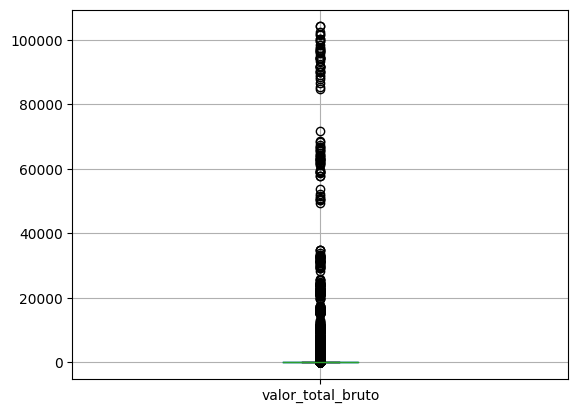

In [ ]:
#box plot
df_tratamento[['valor_total_bruto']].boxplot()

Ainda assim existem dados com valores bem altos (outliers). Entretanto, analisando os casos separadamente, não parecem ser erros, apenas compras pouco usuais.

**Exercício 4**

In [ ]:
#Converter a coluna 'data' para o formato de data
df_tratamento['data'] = pd.to_datetime(df_tratamento['data'], format='%d/%m/%Y')
df_tratamento['data_formato_novo'] = pd.to_datetime(df_tratamento['data'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

#Filtrar o DataFrame para incluir apenas o produto "Penas Gatito"
produto_escolhido = "Penas Gatito"
df_produto_escolhido = df_tratamento[df_tratamento['produto'] == produto_escolhido]

grupo_por_mes_ano_produto = df_produto_escolhido.groupby([df_produto_escolhido['data'].dt.to_period('M')])['quantidade'].sum()


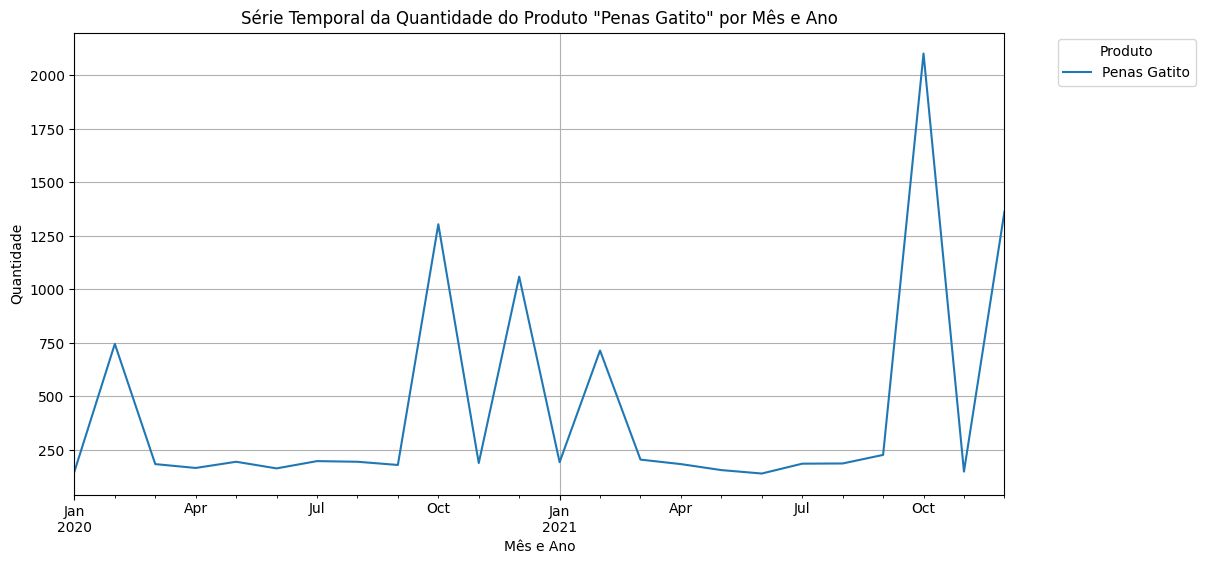

In [ ]:
#A. Criar um gráfico de linha para a série temporal de quantidade de produto por mês e ano
plt.figure(figsize=(12, 6))
grupo_por_mes_ano_produto.plot()
plt.title(f'Série Temporal da Quantidade do Produto "{produto_escolhido}" por Mês e Ano')
plt.xlabel('Mês e Ano')
plt.ylabel('Quantidade')
plt.grid(True)
plt.legend([produto_escolhido], title='Produto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
#B. Aplicar o teste de estacionariedade.
result = adfuller(grupo_por_mes_ano_produto)
print('Estatística ADF:', result[0])
print('P-Value:', result[1])
print('Valores críticos:', result[4])

if result[1] <= 0.05:
    print('A série é estacionária.')
else:
    print('A série não é estacionária e pode precisar de transformação.')


Estatística ADF: -2.039245275812784
P-Value: 0.269634810328626
Valores críticos: {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}
A série não é estacionária e pode precisar de transformação.


In [ ]:
#C. Aplicar o teste de estacionariedade da série transformada
#Fazer a transformação
serie_temporal_diferenciada = grupo_por_mes_ano_produto.diff(periods=1).dropna()
result_diferenciado = adfuller(serie_temporal_diferenciada)

#Imprimir resultado da transformação
print('Estatística ADF após a transformação:', result_diferenciado[0])
print('P-Value após a transformação:', result_diferenciado[1])
print('Valores críticos após a transformação:', result_diferenciado[4])

if result_diferenciado[1] <= 0.05:
    print('A série transformada é estacionária.')
else:
    print('A série transformada não é estacionária e pode precisar de transformação adicional ou outra abordagem.')


Estatística ADF após a transformação: -11.900888467629898
P-Value após a transformação: 5.578806122883552e-22
Valores críticos após a transformação: {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}
A série transformada é estacionária.


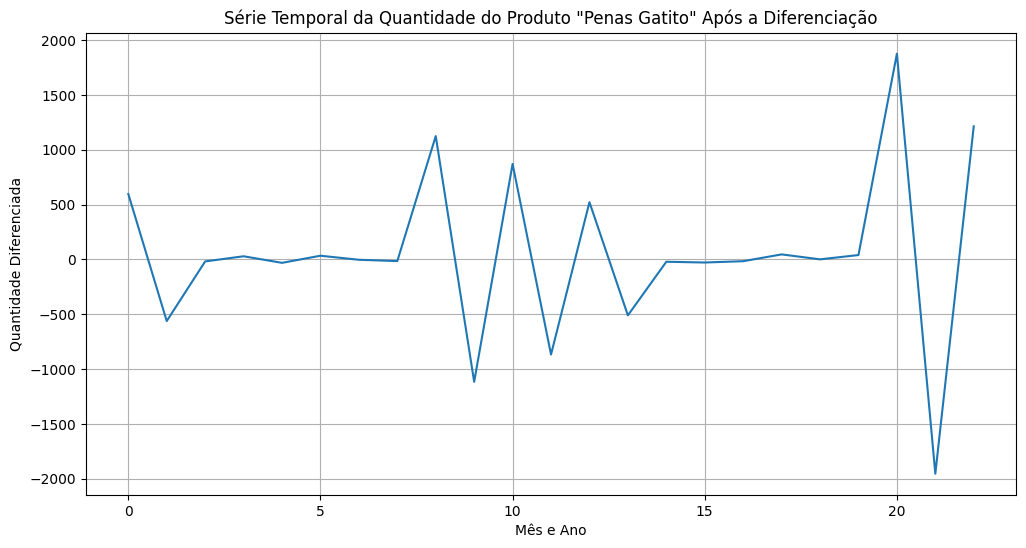

In [ ]:
#D. Gráfico da série transformada
#Converter a série temporal para um formato numérico
serie_temporal_diferenciada = np.array(serie_temporal_diferenciada)

#Criar um gráfico da série transformada diferenciada
plt.figure(figsize=(12, 6))
plt.plot(serie_temporal_diferenciada)
plt.title(f'Série Temporal da Quantidade do Produto "{produto_escolhido}" Após a Diferenciação')
plt.xlabel('Mês e Ano')
plt.ylabel('Quantidade Diferenciada')
plt.grid(True)
plt.show()


**Exercício 5**

In [ ]:
#Após aplicar a limpeza e tratamento nos dados, calcule a média e mediana por categoria de produto e o ranking dos produtos mais vendidos.
#Agrupar por categoria e calcular a media e mediana
grupo_por_categoria = df_tratamento.groupby('categoriaprod')
media_qtd_por_categoria = grupo_por_categoria['quantidade'].mean()
mediana_qtd_por_categoria = grupo_por_categoria['quantidade'].median()
media_valor_por_categoria = grupo_por_categoria['valor'].mean()
mediana_valor_por_categoria = grupo_por_categoria['valor'].median()

resumo_por_categoria = pd.DataFrame({'Média quantidade': media_qtd_por_categoria, 'Mediana quantidade': mediana_qtd_por_categoria, 'Média valor': media_valor_por_categoria, 'Mediana valor': mediana_valor_por_categoria})
(resumo_por_categoria)

,Média quantidade,Mediana quantidade,Média valor,Mediana valor
categoriaprod,,,,
Acessório,3.135114,1.0,54.047957,45.22
Alimentação,4.069991,2.0,109.177731,54.53
Bebedouros e Comedouros,2.697003,1.0,530.660975,851.20
Brinquedo,3.297683,1.0,19.285655,19.04
Higiene e Limpeza,3.111727,1.0,48.832497,38.57
Medicamento,3.554737,2.0,158.366134,81.76
Petisco,3.608583,2.0,27.319203,32.48


In [ ]:
#Ranking de produtos mais vendidos por quantidade
grupo_por_produto = df_tratamento.groupby('produto')
total_vendido_por_produto = grupo_por_produto['quantidade'].sum()
ranking_produtos = pd.DataFrame({'Total Vendido': total_vendido_por_produto})
ranking_produtos_ordenado = ranking_produtos.sort_values(by='Total Vendido', ascending=False)

print(ranking_produtos_ordenado)

                                                    Total Vendido
produto                                                          
Biscoito  True Champion 300g                                17823
Shampoo vegano para cachorro e gato de camomila...          15742
Ração Úmida Royal Canin Lata Veterinary Cães Ad...          15158
Bandana Disney Mickey Fábrica Petti                         15005
Meias esportivas para cães para ambientes inter...          14912
Mordedor de Corda Bola                                      14552
Ração Royal Canin Exigent Gatos Adultos 1,5Kg               14166
Whiskas Petisco Temptations Anti Bola de Pelo 40g           14057
Vitamina E Granulado BigForce                               13493
Antipulgas e Carrapatos MSD Bravecto para Pet d...          13265
Pote Petisco Para Cachorro Bifinho Sabor Carne ...          13219
Ração Royal Canin Club Performance para Cães Ad...          13097
Cama Coração Coroa Pet Nest Almofada Lavável                12521
Suplemento

In [ ]:
#Ranking de produtos mais vendidos por pedido

# Agrupar o DataFrame por cada pedido e contar o número de ocorrências de cada produto em cada grupo
grupo_por_pedido = df_tratamento['produto'].value_counts().reset_index(name='quantidade_pedida')

# Ordenar o DataFrame pelo número de ocorrências de produtos em cada pedido (quantidade_pedida) em ordem descendente
ranking_produtos_por_pedido = grupo_por_pedido.sort_values(by='quantidade_pedida', ascending=False)

# Agora, ranking_produtos_por_pedido contém o ranking de produtos mais pedidos por pedido
(ranking_produtos_por_pedido)

,index,quantidade_pedida
0,Mordedor de Corda Bola,4140
1,Meias esportivas para cães para ambientes inte...,4120
2,Cama Coração Coroa Pet Nest Almofada Lavável,4120
3,Roupa para Cão Billaboard,4112
4,Roupa para Gato Petti,4110
5,Cama média almofadada Pity,4103
6,Kit Banho e Tosa com Escova PetShop Cãopeon,4097
7,Nutri Alimentador Inteligente Automático Câmer...,4096
8,Penas Gatito,4093
9,Escova Pet Rasqueadeira Tira Pelos Cachorro e ...,4080
